In [1]:
import csv
import math
import pickle
import gzip
import random
import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
import matplotlib.pylab as plt

In [2]:

df = pd.read_csv('data/data_sanitized.csv')

K = 10 #K! hyperparameter!
N = len(df)
print(N)
valid_ids = np.asarray(random.sample(range(N), int(N/5)))
train_ids = np.asarray([i for i in range(N) if i not in valid_ids])

def distance(data1, data2, p, weights, ids):
    return np.abs(np.sum((data1[ids].to_numpy()*weights-data2[ids].to_numpy()*weights)**p))**(1/p) 

ids     = [0,2,3,4,5,6,7,8]
weights = [1,1,1,1,1,1,1,1]
#for i in train_ids:  #lloooooooooong runtime
    #for j in train_ids:
        #print(" i: {} j: {} Distance: {}".format(i,j,distance(df.iloc[j],df.iloc[i], 1, [1,1,1,1,1,1,1,1],ids)))


24344


In [3]:
class covid_K_means:
    def __init__(self,df,train_ids,valid_ids,feature_ids,weights,K,p,tol):
        self.train_data  = df.iloc[train_ids] #training split
        self.valid_data  = df.iloc[valid_ids] #validation split
        self.predictions = np.zeros([len(valid_ids)]) #prediction array for validation
        self.feature_ids = feature_ids #feature split (ran out of time to tune)
        self.weights     = weights     #feature weights (ran out of time to tune)
        self.clustroids  = self.train_data.sample(K,replace = False) #initial (random) k clustroids
        self.centroids   = np.zeros([K,len(self.feature_ids)]) #array for k centroids
        self.distances   = np.full([K],1000000) # distance array for clustering part
        self.clusters    = [] #cluster list
        self.labels      = [] #label list
        self.k           = K  
        self.p           = p
        self.score_val   = 0
        self.avg_dist    = 0
        self.tol         = tol
        for clustroid in self.clustroids: self.labels.append(clustroid)
        for i in range(self.k): self.clusters.append([self.clustroids.iloc[i][self.labels]])
            
        
        
    def cluster(self):
        for point_index in range(len(self.train_data)): #go over each data point
            for j in range(self.k):                       # go through each clustroid
                self.distances[j] = self.distance(self.train_data.iloc[point_index],self.clustroids.iloc[j],self.p,self.weights,self.feature_ids)  # and calculate distance to clustroid.
            index = np.argmin(self.distances)                                     # Get the index of the closest clustroid
            #print("assigned to cluster number:",index, self.distances[index],self.distances)
            self.clusters[index].append(self.train_data.iloc[point_index][self.labels])
            
                
    def compute_centroids(self):
        for index in range(self.k): #for each cluster
            centroid  = np.zeros([len(self.feature_ids)]) #new centroid
            distances = np.zeros([len(self.clusters[index])]) #distances for finding clustroid
            
            for point_index in range(len(self.clusters[index])): #go through each point in cluster
                centroid = centroid + self.clusters[index][point_index][self.labels].to_numpy()[self.feature_ids] 
                #go through each data point so we can average, must loop since its a list
            self.centroids[index] = centroid / len(self.clusters[index]) #averages the data points in each cluster by feature
            
            for jndex, point in enumerate(self.clusters[index]): #find clustroid
                distances[jndex] = self.centroid_distance(point,self.centroids[index],self.p,self.weights,self.feature_ids)
            jndex = np.argmin(distances)
            self.clustroids[index] = self.clusters[index][jndex] #assign clustroid
        for i in range(self.k): self.clusters.append([self.clustroids.iloc[i][self.labels]]) #start with centroids

            
    def distance(self, data1, data2, p, weights, ids): #p norm distance function 
        return np.abs(np.sum((data1[ids].to_numpy()*weights-data2[ids].to_numpy()*weights)**p))**(1/p) 
    
    def centroid_distance(self, data1, data2, p, weights, ids): #used for dist to centroid
        return np.abs(np.sum((data1[ids].to_numpy()*weights-data2*weights)**p))**(1/p) 

    
    def fit(self): 
        cloysters = self.clusters 
        for i in range(1000):
            self.cluster()      #cluster the data
            self.compute_centroids() #compute new centroids
            if cloysters == self.clusters: break # if the clusters didn't change, then we converged
            cloysters = self.clusters # else, save the clusters so we can check next iteration
        self.score() #score after we converge9
            
    def predict(self): #prediction with k clusters by finding nearest clustroid, then generating a guess by random sample of cluster
        for point_index in range(len(self.valid_data)): #go over each data point
            for j in range(self.k):                       # go through each clustroid
                self.distances[j] = self.distance(self.valid_data.iloc[point_index],self.clustroids.iloc[j][self.labels],self.p,self.weights,self.feature_ids)  # and calculate distance to centroid.
            index = np.argmin(self.distances) #finds clustroid
            size = 5
            if len(self.clusters[index])<5: size = self.clusters[index] #finds sample size if less than 5
            sample = random.sample(self.clusters[index],size) #gets random sample
            for i in sample: self.predictions[point_index] += i[self.labels[4]] 
            self.predictions[point_index]/=len(sample) #average the sample for our prediction
    
    
    def score(self): #score counts the ratio of predictions within a certain tolerance of the real value
        self.predict()
        self.avg_dist_to_centroid()
        score = 0
        for i in range(len(self.predictions)):
            dist_ratio = np.abs(self.predictions[i]-self.valid_data.iloc[i][self.labels[4]])/self.predictions[i]
            if dist_ratio < self.tol:
                score+=1
        score/=len(self.predictions)
        self.score_val = score
        print("Score for",self.k,"clusters: ",score,"(ratio of points within tolerance)")
    
    
    def avg_dist_to_centroid(self): #for elbow plot
        dist = 0
        for i in range(len(self.clusters)):
            for j in range(int(len(self.clusters[i])/2)-1):
                dist += self.distance(self.clusters[i][j], self.clustroids.iloc[i][self.labels], self.p,self.weights,self.feature_ids)
        self.avg_dist = dist/len(self.train_data)
        
            
        

In [4]:
Ks = [2,6,12,24,64,150,365]
k_clusters = []
for k in Ks:
    k_cluster = covid_K_means(df,train_ids,valid_ids,ids,weights,k,1,0.15)
    k_cluster.fit()
    k_clusters.append(k_cluster)
    

<ipython-input-3-1d6533fb0799>:82: RuntimeWarning: invalid value encountered in double_scalars
  dist_ratio = np.abs(self.predictions[i]-self.valid_data.iloc[i][self.labels[4]])/self.predictions[i]
<ipython-input-3-1d6533fb0799>:82: RuntimeWarning: divide by zero encountered in double_scalars
  dist_ratio = np.abs(self.predictions[i]-self.valid_data.iloc[i][self.labels[4]])/self.predictions[i]


Score for 2 clusters:  0.047041906327033686 (ratio of points within tolerance)
Score for 6 clusters:  0.0585456039441249 (ratio of points within tolerance)
Score for 12 clusters:  0.06183237469186524 (ratio of points within tolerance)
Score for 24 clusters:  0.05608052588331964 (ratio of points within tolerance)
Score for 64 clusters:  0.06491372226787182 (ratio of points within tolerance)
Score for 150 clusters:  0.07210353327855382 (ratio of points within tolerance)
Score for 365 clusters:  0.07210353327855382 (ratio of points within tolerance)


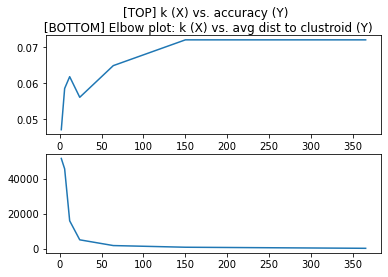

In [6]:
scores = []
elbows = []
for k in k_clusters:
    scores.append(k.score_val)
    elbows.append(k.avg_dist)
fig, axs = plt.subplots(2)
fig.suptitle("[TOP] k (X) vs. accuracy (Y) \n [BOTTOM] Elbow plot: k (X) vs. avg dist to clustroid (Y) ")
axs[0].plot(Ks, scores)
axs[1].plot(Ks, elbows)

Details:

This k means program clusters data points on manhattan distance using all features. The features are Days Since March 17, County, Population, Total Sum Cases, New Cases per Day, Average Cases Per 7 Days, Average Daily Change in Cases Per 7 Days, Area of County, and Number of MIP Charges. Since the manhattan distance is used and all features are equally weighted, we think that days since march 17 and total sum cases are skewinig the clusters since they chronologically increase. Further inquiry into performance would be to mess with feature dropout and random weighting to see what results in the highest accuracy. Runtimes for our 7 values of k with a single set of hyperparameters takes about 3 hours, so further tuning wasn't possible under our time constraints. These runtimes are to be expected because K means clustering is an NP-hard problem, so even for our relatively small data set we see long runtimes.

K means is also not a supervised learning method, so predicting a value using K means was unclear and we settled on an intuitive but unproven method. This method is described in the code, but essentially averages a random sample from the closest cluster of points. 


Results:

As we can see from our results, the accuracy had a significant positive correlation which is reassuring. Our elbow plot behaved as expected, further assuring the K means implementation is correct. The overall accuracy however is quite poor, ranging from 4% to 7% accuracy. This is obviously very poor, and a baseline that we would like to compare to is the random classifier. As mentioned in the details, we know that some features were bad. To get around this, we would want to run this with random feature sets to see which features behave poorly other than the ones we already suspect. Most likely we would run these random feature sets with $k = 24$ as suggested by our elbow plot. If we are still not satisfied after feature set tuning, we can then tune feature weights. 